# HOMEWORK 3

# PART A : PORTFOLIO OPTIMIZATION 

# PROBLEM A1 

# 1ST PART -  Find optimal weights for this portfolio (all five stocks) to 
# minimize portfolio variance

In [127]:
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

In [128]:
adj_close_mv = pd.DataFrame()
tickers_mv = ["META", "MA", "XOM", "JNJ", "COST"]
end_date_mv = datetime.today()
start_date_mv = end_date_mv - timedelta(days = 318)

for ticker in tickers_mv:
    data_mv = yf.download(ticker, start = start_date_mv, end = end_date_mv)
    adj_close_mv[ticker] = data_mv["Adj Close"]
print(adj_close_mv)    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                  META          MA         XOM         JNJ        COST
Date                                                                  
2023-05-15  238.606842  381.700500  102.320419  154.789505  488.336151
2023-05-16  238.566879  378.544678   99.837151  154.585785  482.606903
2023-05-17  242.232986  385.274506  102.076958  154.246231  481.488312
2023-05-18  246.588379  390.272125  103.002098  153.751434  484.503632
2023-05-19  245.379654  383.850922  103.479271  154.168625  482.966797
...                ...         ...         ...         ...         ...
2024-03-19  496.239990  484.000000  113.089996  156.210007  732.169983
2024-03-20  505.

In [154]:
 print('meta : ' , adj_close_mv['META'].var()/100 , 'xom :   ' , adj_close_mv['XOM'].var()/100 , ' cost : ' ,  adj_close_mv['COST'].var()/100 , ' ma :  ' , adj_close_mv['MA'].var()/100, ' jnj  : ' ,  adj_close_mv['JNJ'].var()/100 )

meta :  51.87253554354781 xom :    0.22827738768151196  cost :  69.36997532309086  ma :   10.143246824379071  jnj  :  0.3104996971883302


In [129]:
bounds_mv = [(0,1) for _ in range(len(tickers_mv))]
constraints_mv = {'type': "eq" , "fun":lambda weight_mv:np.sum(weight_mv) - 1}

In [130]:
initial_weight_mv = np.array([1/len(tickers_mv)]*len(tickers_mv))
initial_weight_mv

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [131]:
logreturns_mv = np.log(adj_close_mv/adj_close_mv.shift(1))
covmatrix_mv = logreturns_mv.cov()*252
covmatrix_mv = covmatrix_mv.dropna()
covmatrix_mv

,META,MA,XOM,JNJ,COST
META,0.117298,0.017630,-0.007840,-0.004226,0.021517
MA,0.017630,0.027686,0.003092,0.004201,0.010496
XOM,-0.007840,0.003092,0.046001,0.004104,-0.000211
JNJ,-0.004226,0.004201,0.004104,0.022947,0.002500
COST,0.021517,0.010496,-0.000211,0.002500,0.035371


In [132]:
def exp_ret_mv(weight_mv,logreturn_mv):
    return np.sum(logreturns_mv.mean()*weight_mv)*252 
def variance_mv(weight_mv,covmatrix_mv):
    var_mv = weight_mv.T @ covmatrix_mv @ weight_mv
    return np.sqrt(var_mv) 

In [133]:
optimizedweights_mv = minimize(variance_mv, initial_weight_mv, args = (covmatrix_mv), method = "SLSQP", constraints = constraints_mv, bounds = bounds_mv)
optimizedresults_mv = optimizedweights_mv.x
optimizedresults_mv

array([0.05323395, 0.20026601, 0.19077097, 0.37685886, 0.17887021])

In [134]:
print("total:" , optimizedresults_mv.sum(),"variance:", optimizedresults_mv.T@covmatrix_mv@optimizedresults_mv)

total: 1.0 variance: 0.010499671068162783


# Part B - Black - Litterman model for 5 stocks 

In [135]:
import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models, expected_returns
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns

In [136]:
market_caps_bl = {
    'META': 1250000000000, 
    'MA': 443900000000, 
    'XOM': 441500000000, 
    'JNJ': 381020000000, 
    'COST': 321620000000
}
s_bl = risk_models.sample_cov(adj_close_mv)
mu_bl = expected_returns.mean_historical_return(adj_close_mv)

total_market_cap_bl = sum(market_caps_bl.values())
market_weights_bl = {ticker: cap / total_market_cap_bl for ticker, cap in market_caps_bl.items() if ticker in adj_close_mv.columns}
assert set(market_weights_bl.keys()) == set(s_bl.columns), "Tickers"
market_weights_series_bl = pd.Series(market_weights_bl, index=s_bl.columns)
delta_bl = black_litterman.market_implied_risk_aversion(mu_bl)

prior_bl = delta_bl * s_bl.dot(market_weights_series_bl)
viewdict_bl = {"META": 0.30, "MA": 0.25, "XOM": 0.10, "JNJ": 0.40, "COST": 0.15}
bl = BlackLittermanModel(s_bl, pi=prior_bl, absolute_views=viewdict_bl)
rets_bl = bl.bl_returns()

ef_bl = EfficientFrontier(rets_bl, s_bl)
bl_weights = ef_bl.max_sharpe()
cleaned_weights_bl = ef_bl.clean_weights()
print("Black Lit Weights")
print(cleaned_weights_bl)

Black Lit Weights
OrderedDict([('META', 0.07583), ('MA', 0.23631), ('XOM', 0.02626), ('JNJ', 0.60827), ('COST', 0.05334)])


In [137]:
cleaned_w_bl = np.array(cleaned_weights_bl.values())
cleaned_w_bl

array(odict_values([0.07583, 0.23631, 0.02626, 0.60827, 0.05334]),
      dtype=object)

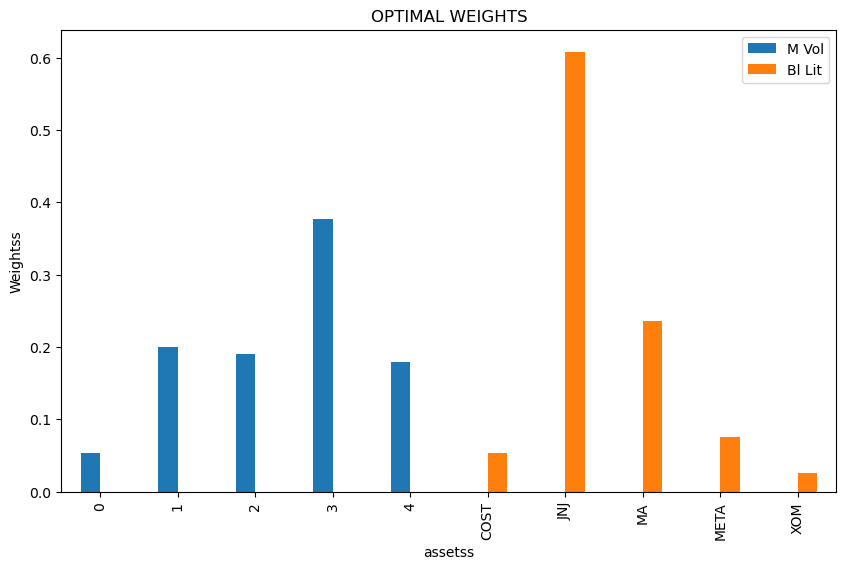

In [138]:
import matplotlib.pyplot as plt
min_vol_series_mv = pd.Series(optimizedresults_mv)
bl_series = pd.Series(cleaned_weights_bl)
weights_df = pd.DataFrame({
    'M Vol': min_vol_series_mv,
    'Bl Lit': bl_series
})
weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('OPTIMAL WEIGHTS')
plt.ylabel('Weightss')
plt.xlabel('assetss')
plt.show()

# Here, the blue bars are the ones representing the optimized weights we got by Minimum Portfolio Voltality 
# and the orange bars represent the optimized weights we got by Black Litterman model.

""""For distinction I have labelled the minimum voltality weights in numbers for which i am givoing corresponding 
weights below and the balck litterman weights by name just for distinction

0 - META 
1 - MA 
2 - XOM 
3 - JNJ 
4 - COST

Looking at the graph, we can see the results : 
 
MIN VAR :                                               BLACK LITTERMAN : 

META : 5.3%                                                 META :  7.583 %
MA : 20.02%                                                 MA : 23.63%
XOM:19.07%                                                  XOM :2.626%
JNJ:37.68%                                                  JNJ : 60.82%
COST :17.88%                                                COST : 5.33%

MINIMUM VARIANCE PORTFOLIO - 
Since , minimum portfolio variance method focus on minimizing protfolio variance , it tends to allocate more and more weight to stocks whiose historical returns showcase lower variance and who historical returns are less correlated with the histroical returns of over stocks. As I calculated the variance above, we can see can JNJ has the lowest variance as compared to other stocks and if we look at the covariance matrix, we can see that that JNJ is very less co related and infact has negative correlation with a stock which makes it the stock with the highest weight in the minimum variance portfolio.

Now, looking at the other stocks like MA, XOM, COST , which has minimal difference in the proportion of weights we can see that these have high variances as compared to jnj and in bestween them too , there are differed in variance and correlation such that MA is invested 20.02% , XOM IS 19.07 % , and COST IS 17.88%. 

So, we can say that yes, the minimum variance portfolio is more senstive to the volatlity and correlation among stocks and so this method has sort of conservative approach if we talk about investing . 

Now, here is the structured analysis of the minimum variance protfolio :

META - With a share of 5.3% , it implies that it must be having high variance(calculated above in code , it is aroudn 51%) it is so highly volatiel and so will be less preferable for a investor looking for minimum variance portfolio even if it may deliver higher returns than other assests. in this case more than maximising return , the investor is more concerned of decreasing overall portfolio variance and ao less weight is assigned to meta . 

MASTER CARD (MA) - With a share of 20.02% , it depicts that MA is contributing to risk reduction lower risk and correlation of its historical returns with other assets. 

XOM - With a share of 19.07% , similar but a littless than share of MASTERCARD , it offers benefits of diversification, though itr has higher variance of 22% instead of 10% of MA , it is much less and even negatively correlated with 2 assets in the portfolio . 

JNJ - It has the highest weight of 37.68% in the portfolio, thoigh it has high variance of 31% , it is much less correlated to the returns of other stocks which compensates it for its high variance and so makes it overall less risky and volatile to invest and hence seen as a much reliable investment . 


cost - With share of 17.88% gives the portfolio consistency and less risk with its variance and correlation . 


The minimum variance portfolio's structure showcases stability and risk reduction making it the best choice for the investors who want to conserve rtheir capital and have least risk and losses possible, so it priortizes and focuses on risk management over geenrating highest returns possible as it totally depends on risk aversion of the investor. 

Also, we can see that there is benefit of diversification, here sector diversification as it tries to minimise the portfolio variance while creating a balance between stocks in different industries like fintech , IT , consumer staples etc. 


Black lITTERMAN mODEL - 

The model is an portfolio optimization model used taking into consideration investors risk preference and market views . It basically starts from initial point of modern portfolio theory as the base but then it takes into account and then takes investors views and adjust its weights accordingly. 

JNJ - The major share of 60.82% in JNJ suggests showcase strong market view and less assumed risk in jnj showcasing strong investor confidence. To verify this , please refer to the code in the above cells where I have take view that it would be growing by 40% . It also had highest share in the minimum variance protfolio suggesting it as the best stock to invest in in both the models . 

XOM - It has very less weight shrae in the portfolio of 2.62% compared to its share(19.07%) in minimum variance portfolio as it is has market view of just 10% perception of growth and so it can definitely be reflected in the lack litterman model. 

MA - It has a share of 23.63% in the black litterman model portfolio as compared to 20.02% in min var portfolio which depicts investor confidence in the asset , also since it has sentiment of market views of 0.25 . 

META - It has somewhat same and lowest allocation in both the optinmized portfolios which means that it has huge voltality , less investor con fidence and also that it is risky to invest it , though it may have a market view of 0.30 , it is highly volatiel. 

COSTCO - The protfolio allocation of costco decreased from 17.88 % in min var portfolio to 5.33 % in black litterman model which means that it has less less investor confidence and it is proved if we see the above code cells as it has 0.15 in market views. 

So, all in all , greater weightage is given to those stocks which has higher positive market views sentiment as compared to stock with lower . 
""""""

# PROBLEM A2 

In [140]:
end_date_cmr = datetime.today()
start_date_cmr = end_date_cmr - timedelta(days = 318)
adj_close_cmr = pd.DataFrame()
tickers_cmr = ["AVAX-USD", "SHIB-USD", "DOT-USD", "TRX-USD", "LINK-USD"]
for ticker_cmr in tickers_cmr:
    data_cmr = yf.download(ticker_cmr, start = start_date_cmr, end = end_date_cmr)
    adj_close_cmr[ticker_cmr] = data_cmr["Adj Close"]
print(adj_close_cmr)    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
             AVAX-USD  SHIB-USD   DOT-USD   TRX-USD   LINK-USD
Date                                                          
2023-05-12  15.192853  0.000009  5.345988  0.069096   6.621964
2023-05-13  14.942066  0.000009  5.351904  0.069380   6.500390
2023-05-14  15.030250  0.000009  5.354409  0.069401   6.543809
2023-05-15  15.093147  0.000009  5.320286  0.070242   6.638051
2023-05-16  14.903059  0.000009  5.299292  0.070559   6.659044
...               ...       ...       ...       ...        ...
2024-03-20  57.030720  0.000028  9.491859  0.120922  18.406483
2024-03-21  53.865566  0.000027  9.172894  0.121126  18.431383
2024-03-22  53.267067  0.

In [141]:
def exp_ret_cmr(weight_cmr,logreturn_cmr):
    return np.sum(logreturns_cmr.mean()*weight_cmr)*252 
bounds_cmr = [(0,1) for _ in range(len(tickers_cmr))]
constraints_cmr = {'type': "eq" , "fun":lambda weight_cmr:np.sum(weight_cmr) - 1}
initial_weight_cmr = np.array([1/len(tickers_cmr)]*len(tickers_cmr))
initial_weight_cmr

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [159]:
print('avax' , adj_close_cmr['AVAX-USD'].var()/100, 'shib' , adj_close_cmr['SHIB-USD'].var()/100, 'DOT' , adj_close_cmr['DOT-USD'].var()/100, 'TRX' , adj_close_cmr['TRX-USD'].var()/100, 'LINK' , adj_close_cmr['LINK-USD'].var()/100)

avax 1.9416013381883703 shib 3.344389270117682e-13 DOT 0.030735201503405998 TRX 4.027430075434308e-06 LINK 0.2577831657397549


In [142]:
logreturns_cmr = np.log(adj_close_cmr/adj_close_cmr.shift(1))
covmatrix_cmr = logreturns_cmr.cov()*252
covmatrix_cmr = covmatrix_cmr.dropna()
covmatrix_cmr

,AVAX-USD,SHIB-USD,DOT-USD,TRX-USD,LINK-USD
AVAX-USD,0.490216,0.224368,0.267076,0.084589,0.230508
SHIB-USD,0.224368,0.997267,0.196807,0.084281,0.201477
DOT-USD,0.267076,0.196807,0.304708,0.082462,0.223054
TRX-USD,0.084589,0.084281,0.082462,0.096111,0.090588
LINK-USD,0.230508,0.201477,0.223054,0.090588,0.413806


In [143]:
def variance_cmr(weight_cmr,covmatrix_cmr):
    var_cmr = weight_cmr.T @ covmatrix_cmr @ weight_cmr
    return np.sqrt(var_cmr)

In [144]:
optimizedweights_cmr = minimize(variance_cmr, initial_weight_cmr, args = (covmatrix_cmr), method = "SLSQP", constraints = constraints_cmr, bounds = bounds_cmr)
optimizedresults_cmr = optimizedweights_cmr.x
optimizedresults_cmr

array([0.        , 0.00563861, 0.05515753, 0.93920386, 0.        ])

In [145]:
var_cmr = optimizedresults_cmr.T@covmatrix_cmr@optimizedresults_cmr
print("weights sum : ",  optimizedresults_cmr.sum(), "variance : " , var_cmr)

weights sum :  1.0 variance :  0.09529739350598158


# PART B - BLACK LITTERMAN FOR CRYPTOS 

In [97]:
import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models, expected_returns
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
mu_cbl = expected_returns.mean_historical_return(adj_close_cmr)
s_cbl = risk_models.sample_cov(adj_close_cmr)

In [112]:
market_caps_cbl = {
     'AVAX-USD': 20200000000, 
    'SHIB-USD': 14880000000, 
    'DOT-USD': 13780000000, 
    'TRX-USD': 11010000000, 
    'LINK-USD': 11063000000
}
total_market_cap_cbl = sum(market_caps_cbl.values())
market_weights_cbl = {ticker: cap / total_market_cap_cbl for ticker, cap in market_caps_cbl.items() if ticker in adj_close_cmr.columns}
assert set(market_weights_cbl.keys()) == set(s_cbl.columns), "Tickers"
market_weights_series_cbl = pd.Series(market_weights_cbl, index=s_cbl.columns)

delta_cbl = black_litterman.market_implied_risk_aversion(mu_cbl)
prior_cbl = delta_cbl * s_cbl.dot(market_weights_series_cbl)
viewdict_cbl = {"AVAX-USD": 0.45, "SHIB-USD": 0.30, "DOT-USD": 0.33, "TRX-USD": 0.27, "LINK-USD": 0.29}
cbl = BlackLittermanModel(s_cbl, pi=prior_cbl, absolute_views=viewdict_cbl)

rets_cbl = cbl.bl_returns()
ef_cbl = EfficientFrontier(rets_cbl, s_cbl)
cbl_weights = ef_cbl.max_sharpe()

cleaned_weights_cbl = ef_cbl.clean_weights()
print("Bl Lit Weight")
print(cleaned_weights_cbl)

Bl Lit Weight
OrderedDict([('AVAX-USD', 0.18071), ('SHIB-USD', 0.03269), ('DOT-USD', 0.13751), ('TRX-USD', 0.59308), ('LINK-USD', 0.05602)])


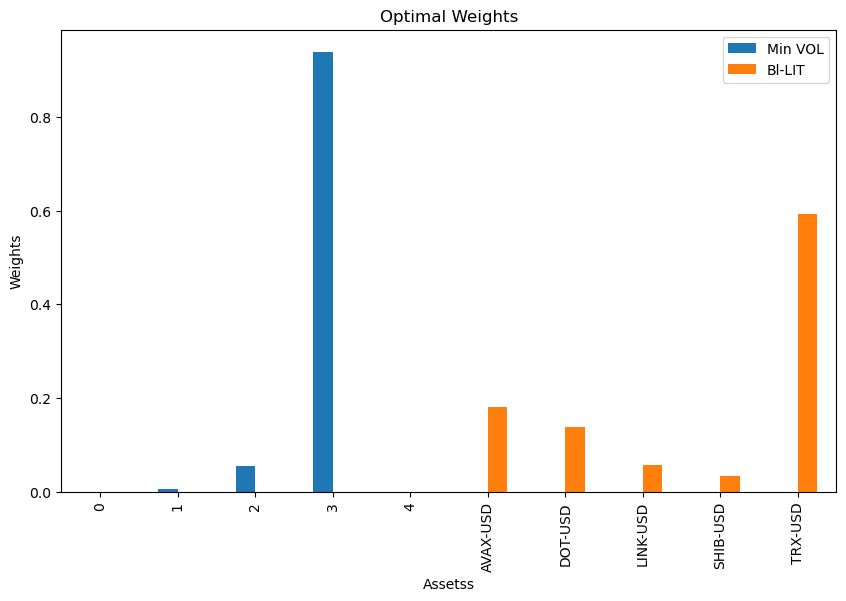

In [116]:
import matplotlib.pyplot as plt
min_vol_series_cmr = pd.Series(optimizedresults_cmr)
cbl_series = pd.Series(cleaned_weights_cbl)
weights_df = pd.DataFrame({
    'Min VOL': min_vol_series_cmr,
    'Bl-LIT': cbl_series
})
weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('Optimal Weights')
plt.ylabel('Weights')
plt.xlabel('Assetss')
plt.show()

"""To avoid confusion, I have labeled the minimum voltality weghts as numbers and the black litterman 
optmized portfolio as names. 

MAX RETURN PORTFOLIO WEIGHTS :  
0 - AVAX - 0%
1 - SHIB - 0.00563%
2 - DOT - 0.05515%
3 - TRX- 0.9392%
4 - LINK -  0% 


BLACK LITTERMAN OPTIMZED PORTFOLIO WEIGHTS : 
AVAX - 0.18071
SHIB - 0.03269
DOT - 0.13751
TRX -  0.59308
LINK - 0.05602


MAX RETURN PORTFOLIO - 

TRX - tHE Min variance portfolio tries to give heavy weightage to TRX, instead it seems more of as a single asset portfolio with 93.2% of TRX, which is because TRX has the lowest oltality ads compared to other stocks and the ther stocks have relatively high voltality o , TRX provides the best diversification benefit to the portfolio and the investor . 

AVAX and LINK - These both are given a weightage of 0% owbing to their high voltality and high correlation with other assests if we look the codes above. Now, if given weightage to them , then our portfolio would not be minimum variance portfolio and their return as compared to their volatlity is not a good as CRYPTO like Trx. 

The black litterman model weights if we see, are kind of more varied and no stock has 0 weightage . but notable is that TRX still has the highest weigtage if compared to other cryotos. but lesser weight than what it had in max return portfolio . THis indicates strong investor confidence in TRX as compared to oter cryptos as its low voltality and high market views gives it such a huge share in the portfolio. 


Coming to SHIB and link, HAS THE LEAST WEIGHTAGE IN The portfolio only because of low market views and high voltality. As black litterman model focus on market views , this result s indeed justified. 

The black litterman model adapts to each investor otlook , view on the crpyto performance , so like next month ifI feel like there is a crypto say ABC , that I beleive to grow by 60% over the time, yes this do happens in case of cryptos like bitcoin, then the midel will try to grant more weightage to ABC , but will keep a diversified portfolio providing diversifcation benefits to investors. 




"""

# Problem A3.  - Descriptive statistics for the optimal portfolios

In [163]:
risk_free_rate = 0.0422

def portfolio_performance(optimizedresults_mv, logreturns, covmatrix, risk_free_rate):
    exp_return = np.sum(logreturns.mean() * optimizedresults_mv) * 252

    variance = optimizedresults_mv.T @ covmatrix @ optimizedresults_mv
    std_dev = np.sqrt(variance)


    sharpe_ratio = (exp_return - risk_free_rate) / std_dev

    return exp_return, variance, std_dev, sharpe_ratio

exp_return_opt, var_opt, std_dev_opt, sharpe_ratio_opt = portfolio_performance(
    optimizedresults_mv, logreturns_mv, covmatrix_mv, risk_free_rate
)

print("Ex Annual Ret: {:.2%}".format(exp_return_opt))
print("Ann Var: {:.4f}".format(var_opt))
print("Annual S D: {:.2%}".format(std_dev_opt))
print("Sharpe Ratio: {:.4f}".format(sharpe_ratio_opt))






Expected Annual Return: 20.86%
Annual Variance: 0.0105
Annual Standard Deviation: 10.25%
Sharpe Ratio: 1.6243


In [171]:
b = [0.07583, 0.23631, 0.02626, 0.60827, 0.05334]
a = np.array(b)

In [172]:
def portfolio_performance(a, logreturns, covmatrix, risk_free_rate):
    exp_return = np.sum(logreturns.mean() * a) * 252

    variance = a.T @ covmatrix @ a
    std_dev = np.sqrt(variance)


    sharpe_ratio = (exp_return - risk_free_rate) / std_dev

    return exp_return, variance, std_dev, sharpe_ratio

exp_return_opt, var_opt, std_dev_opt, sharpe_ratio_opt = portfolio_performance(
    a, logreturns_mv, covmatrix_mv, risk_free_rate
)

print("Ex Annual Ret: {:.2%}".format(exp_return_opt))
print("Ann Var: {:.4f}".format(var_opt))
print("Annual S D: {:.2%}".format(std_dev_opt))
print("Sharpe Ratio: {:.4f}".format(sharpe_ratio_opt))

Ex Annual Ret: 15.74%
Ann Var: 0.0130
Annual S D: 11.42%
Sharpe Ratio: 1.0094


""" Comarison of descriptive statics for both portfolios :   

AX ANNUAL RETURN - The min var portfolio has higher return of 20.86% as compared to black litterman model 
having 15.74%. This depicts though minimizing variance , still the min var portfolio has high return in this case due to 
of its diversifcation benefits and optimization . 

Annual variance and standad variance - Looking at the variance figures , we can 
ideed see that the min var protfolio has a lower variance and yes thats justifiedbecause its basis is that t will over in
invests in sch proportions in stocks which leads to minimum variance of the portfolio .  and so looking at its 
standard devation too, its shows less voltality . 

The high variance and standard deviation in the black litterman model is due to because itconsiders the exected returns to
be as its basis for optmization not the minimum variance. 

Sharpe ratio - The sharpe ratio is higher for the min var portfolio as comapred to the black litterman mdel portfolio
and it shows that the the min var portfolio has better risk adjusted returns and it has higher 
return per unit of risk while the black litterman portfolio shows less return per unit of risk . 

Distribution of returns - 

The black litterman portfolio has high standard deviation meaning that it has sort of wider distribution
of returns which is due to it incorporating market views , whcih means it has high variance and in future
may result in high profits or high losses depending on performance for investors . 

The min var returns are more tightly and less widely distributed as compared to the other models returns , 
significantly indicating that its risk optimization focus and startegy . 

Remarks - The black litterman model , considering investor views and market equuilibrum , 
results in higher profits or higher losses than min var portfolio but seeks a balanced approach taking into 
consideration the stocks future performance. 

The min var portfolio is indeed more risk adjusted and has ighe rsharpe ratio suitable for investors like 
somebody who wants to take least risk possible. 
"""

# PART B: Stock and Crypto Price Simulations

In [22]:
tickers_dj = ["DJIA"]
end_date_dj = datetime.today()
start_date_dj = end_date_dj - timedelta(days = 318)
adj_close_dj = pd.DataFrame()
for ticker_dj in tickers_dj:
    data_dj = yf.download(ticker_dj, start = start_date_dj, end = end_date_dj)
    adj_close_dj[ticker_dj] = data_dj["Adj Close"]
print(adj_close_dj)    

[*********************100%***********************]  1 of 1 completed
                 DJIA
Date                 
2023-05-12  20.347025
2023-05-15  20.403679
2023-05-16  20.205399
2023-05-17  20.526424
2023-05-18  20.564190
...               ...
2024-03-19  22.530001
2024-03-20  22.635000
2024-03-21  22.709999
2024-03-22  22.700001
2024-03-25  22.749901

[218 rows x 1 columns]


In [23]:
simple_returns_dj = data_dj['Adj Close'].pct_change()
log_returns_dj = np.log(data_dj['Adj Close'] / data_dj['Adj Close'].shift(1))
adj_close_dj['simple_returns'] = simple_returns_dj
adj_close_dj['log_returns'] = log_returns_dj
print(adj_close_dj.head())

                 DJIA  simple_returns  log_returns
Date                                              
2023-05-12  20.347025             NaN          NaN
2023-05-15  20.403679        0.002784     0.002781
2023-05-16  20.205399       -0.009718    -0.009765
2023-05-17  20.526424        0.015888     0.015763
2023-05-18  20.564190        0.001840     0.001838


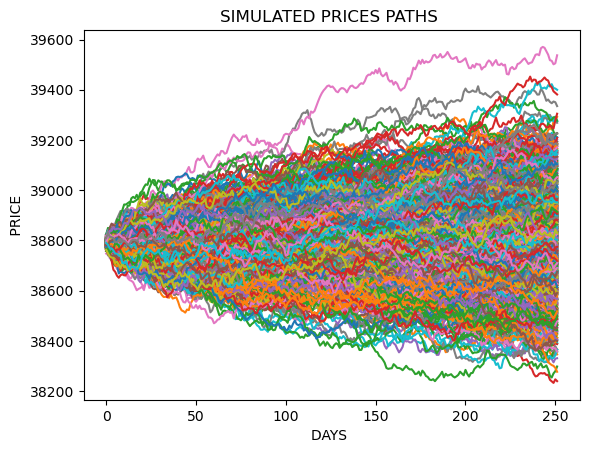

In [123]:
returns = adj_close_dj["simple_returns"]
def simulate_gbm(s0, mu, sigma, n_simulations, t):
    dt = t/n_simulations
    Z = np.random.standard_normal(size=n_simulations)
    step = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    return s0 * np.exp(np.cumsum(step))

s0 = 38790.43  
mu = np.mean(returns)  
sigma = np.std(returns)  

for _ in range(1000):
    simulated_price = simulate_gbm(s0, mu, sigma, 252, 1)
    plt.plot(simulated_price)

plt.title("SIMULATED PRICES PATHS ")
plt.xlabel("DAYS ")
plt.ylabel(" PRICE ")
plt.show()

In [179]:
simulated_price.max()

39022.14208429902

"""  Answering this question as per profile : 

1. Risk loving person - Looking at the graph and calculating in cell above , the best path for a risk 
loving person will the pink path in the above simulation graph, as the risk loving person will be one who will chase the 
highest expected return without caring about the risk  

2. Risk averse person - A Risk averse person will be one who wll choose to take least risk possible and 
those will be price paths below the pink path as taking least risk will be offering lesser returns , that how 
investment works . 

3. Risk neutral person - An investor who focuses on maximum returns instead of risk , he is called
a risk neutral person .Such a person will have price path near the pink price path . """

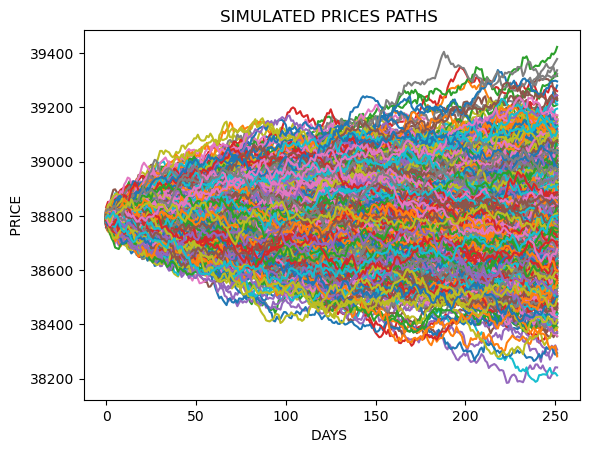

In [183]:
returns = adj_close_dj["log_returns"]
def simulate_gbm(s0, mu, sigma, n_simulations, t):
    dt = t/n_simulations
    Z = np.random.standard_normal(size=n_simulations)
    step = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    return s0 * np.exp(np.cumsum(step))

s0 = 38790.43  
mu = np.mean(returns)  
sigma = np.std(returns)  

for _ in range(1000):
    simulated_price = simulate_gbm(s0, mu, sigma, 252, 1)
    plt.plot(simulated_price)

plt.title("SIMULATED PRICES PATHS ")
plt.xlabel("DAYS ")
plt.ylabel(" PRICE ")
plt.show()

In [184]:
simulated_price.max()

38815.407324459244

# PROBLEM B2

In [25]:
tickers_crp = ["ADA-USD"]
end_date_crp = datetime.today()
start_date_crp = end_date_crp - timedelta(days = 318)
adj_close_crp = pd.DataFrame()
for ticker_crp in tickers_crp:
    data_crp = yf.download(ticker_crp, start = start_date_crp, end = end_date_crp)
    adj_close_crp[ticker_crp] = data_crp["Adj Close"]
print(adj_close_crp)    

[*********************100%***********************]  1 of 1 completed
             ADA-USD
Date                
2023-05-12  0.370463
2023-05-13  0.365031
2023-05-14  0.370761
2023-05-15  0.367482
2023-05-16  0.367830
...              ...
2024-03-20  0.639481
2024-03-21  0.631868
2024-03-22  0.613263
2024-03-23  0.625862
2024-03-24  0.646157

[318 rows x 1 columns]


In [26]:
simple_returns_crp = data_crp['Adj Close'].pct_change()
log_returns_crp = np.log(data_crp['Adj Close'] / data_crp['Adj Close'].shift(1))
adj_close_crp['simple_returns'] = simple_returns_crp
adj_close_crp['log_returns'] = log_returns_crp
print(adj_close_crp.head())

             ADA-USD  simple_returns  log_returns
Date                                             
2023-05-12  0.370463             NaN          NaN
2023-05-13  0.365031       -0.014663    -0.014771
2023-05-14  0.370761        0.015697     0.015575
2023-05-15  0.367482       -0.008844    -0.008883
2023-05-16  0.367830        0.000947     0.000947


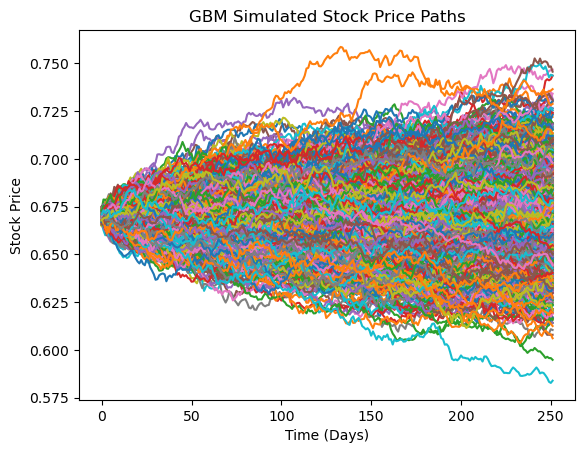

In [119]:
returns_crp = adj_close_crp["simple_returns"]
def simulate_gbm_crp(s0_crp, mu_crp, sigma_crp, n_simulations_crp, t_crp):
    dt_crp = t_crp/n_simulations_crp
    Z_crp = np.random.standard_normal(size=n_simulations_crp)
    step_crp = (mu_crp - 0.5 * sigma_crp**2) * dt_crp + sigma_crp * np.sqrt(dt_crp) * Z_crp
    return s0_crp * np.exp(np.cumsum(step_crp))

s0_crp = 0.67  
mu_crp = np.mean(returns_crp)  
sigma_crp = np.std(returns_crp)  

for _ in range(1000):
    simulated_price_crp = simulate_gbm_crp(s0_crp, mu_crp, sigma_crp, 252, 1)
    plt.plot(simulated_price_crp)

plt.title("GBM Simulated Stock Price Paths")
plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.show()

In [178]:
simulated_price_crp.max()

0.6860238136540125

# log returns 

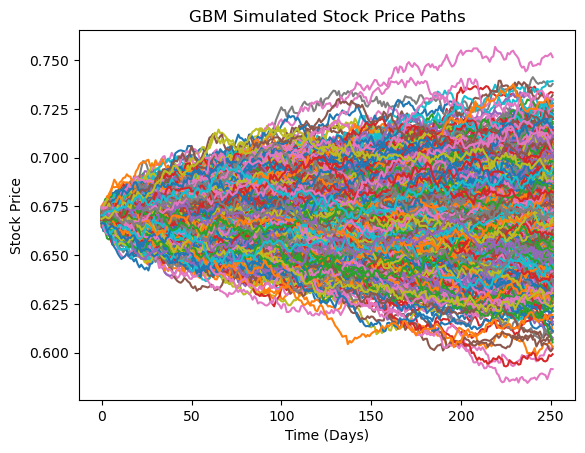

In [181]:
returns_crp = adj_close_crp["log_returns"]
def simulate_gbm_crp(s0_crp, mu_crp, sigma_crp, n_simulations_crp, t_crp):
    dt_crp = t_crp/n_simulations_crp
    Z_crp = np.random.standard_normal(size=n_simulations_crp)
    step_crp = (mu_crp - 0.5 * sigma_crp**2) * dt_crp + sigma_crp * np.sqrt(dt_crp) * Z_crp
    return s0_crp * np.exp(np.cumsum(step_crp))

s0_crp = 0.67  
mu_crp = np.mean(returns_crp)  
sigma_crp = np.std(returns_crp)  

for _ in range(1000):
    simulated_price_crp = simulate_gbm_crp(s0_crp, mu_crp, sigma_crp, 252, 1)
    plt.plot(simulated_price_crp)

plt.title("GBM Simulated Stock Price Paths")
plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.show()

In [182]:
simulated_price_crp.max()

0.6966860275965224

In [ ]:
""" the best price path would be as follows :

1. Risk loving person - A risk loving person in the case of person will try to maxmise his returns 
from crypto investing and his price paths would be somewhere above 0.675 as this kind of investor 
looks at maximum return. 

2, Risk averse person . This will be someone who takes less risk and his price aths would be below 0.675 . 

3. Risk neutral - The investor who does account for risk and try to maximise return. The price paths would be much 
more above the 0.675 as the returns such an investor would be getting would be much larger . but there 
is also big probability that there can be huge losses as the risk is not taken into consideration while making investment . 

